<a href="https://colab.research.google.com/github/spttleonardo/Multi-class_Classification_handWritten_Digits/blob/main/Multi_class_Classification_handWritten_Digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Este Colab aborda a aplicação de classificação multiclasse e redes neurais para o reconhecimento de dígitos manuscritos. Inicialmente, utiliza-se a abordagem um contra todos para classificar os dígitos por meio de regressão logística. Em seguida, é desenvolvida uma função baseada em redes neurais de múltiplas camadas, com o objetivo de aprimorar a acurácia na predição das classes.

UTILIZANDO CLASSIFICAÇÃO MULTICLASSE

In [40]:
# Importando módulos
import os
import numpy as np
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat

In [41]:
# definindo a input layer
input_layer_size = 400

# definindo o numero de labels
num_labels = 10

data = loadmat("/content/ex3data1.mat")
X,y = data['X'], data['y'].ravel() # ravel é utilizado para transforma y em 1D

y[y == 10] = 0 # corrigindo classe 10 para ser 0

m = y.size # obtendo o tamanho

In [42]:
# função para apresentar as imagens
def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Displays 2D data stored in X in a nice grid.
    """
    # Compute rows, cols
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promote to a 2 dimensional array
    else:
        raise IndexError('Input X should be 1 or 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Compute number of items to display
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = pyplot.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_width, order='F'),
                  cmap='Greys', extent=[0, 1, 0, 1])
        ax.axis('off')


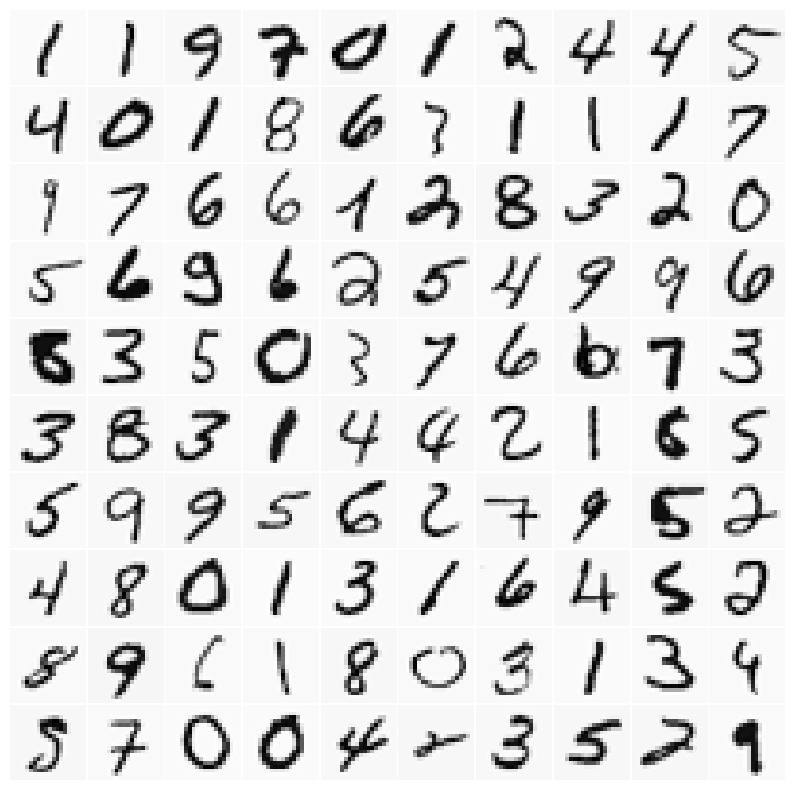

In [43]:
# Aprensentando de forma aleatórias imagens dos numeros
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]
displayData(sel)

In [44]:
# Testando valores para theta
theta_t = np.array([-2, -1, 1, 2], dtype=float)

# Testabti valores para as entradas
X_t = np.concatenate([np.ones((5, 1)), np.arange(1, 16).reshape(5, 3, order='F')/10.0], axis=1)

# Tetando valores das labels
y_t = np.array([1, 0, 1, 0, 1])

# Testando o parâmetro de regularização
lambda_t = 3

In [48]:
# Função para obter a função custo e o gradiente
def lrCostFunction(theta, X, y, lambda_):

    m = y.size

    # convertendo o tipo do y
    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    grad = np.zeros(theta.shape)

    # Calculando hipoteses
    h = theta @ X.T
    g = 1/(1 + np.exp(-h))

    # Entropia cruzada
    J = ((-y.T @ np.log(g)) - ((1-y.T)@ np.log(1-g)))/m + (lambda_/(2*m))*np.sum(theta[1:]**2)

    # Gradiente sem regularização
    grad = (X.T @ (g - y)) / m

    # Regularização: Não regulariza o primeiro parâmetro (θ0)
    grad[1:] += (lambda_ / m) * theta[1:]


    return J, grad

In [50]:
# Testando a função com os valores criados
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

print('Cost         : {:.6f}'.format(J))
print('Expected cost: 2.534819')
print('-----------------------')
print('Gradients:')
print(' [{:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Expected gradients:')
print(' [0.146561, -0.548558, 0.724722, 1.398003]');

Cost         : 2.534819
Expected cost: 2.534819
-----------------------
Gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]
Expected gradients:
 [0.146561, -0.548558, 0.724722, 1.398003]


In [8]:
# Função um contra todos para obter os valores dos thetas utilizando optimize
def oneVsAll(X, y, num_labels, lambda_):

    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))

    # Adicionando o o vetor coluna de 1s por causa do bias
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # Inicializando o theta
    initial_theta = np.zeros(X.shape[1])
    options = {'maxiter': 50}

    for c in range(num_labels):
         res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)
         all_theta[c,:] = res.x


    return all_theta

In [9]:
# Obtendo os valores de theta através do lambda igual a 0.1
lambda_ = 0.1
all_theta = oneVsAll(X, y, num_labels, lambda_)

In [10]:
# Função para obter o digito de cada imagem
def predictOneVsAll(all_theta, X):

    m = X.shape[0];
    num_labels = all_theta.shape[0]
    p = np.zeros(m)
    X = np.concatenate([np.ones((m, 1)), X], axis=1)

    # Calculando hipotese
    z = X @ all_theta.T
    g = 1/(1+np.exp(-z))

    # Obtendo a classe através do valor maximo
    p = np.argmax(g, axis = 1)

    return p

In [11]:
# Predizendo as classes para obter a acuracia
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy: {:.2f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 94.84%


UTILIZANDO REDE NEURAL

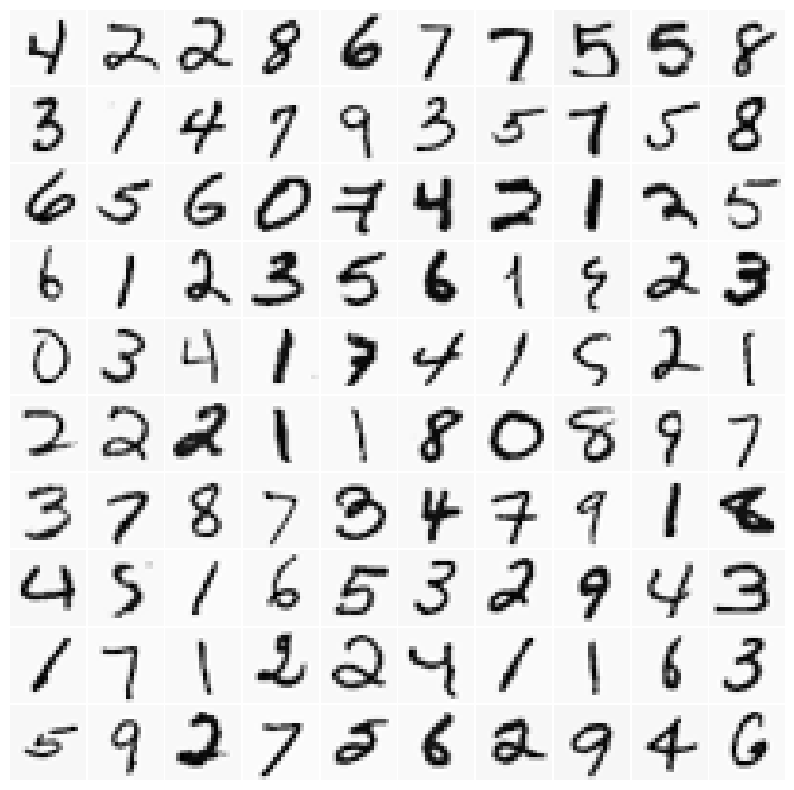

In [12]:
# Carregando dados de treinamento
data = loadmat("/content/ex3data1.mat")
X, y = data['X'], data['y'].ravel()

# mudando classe 10 para 0
y[y == 10] = 0

m = y.size

# permutação randomicas dos exemplos
indices = np.random.permutation(m)

# Seleção randomica de 100 exemplos para plot
rand_indices = np.random.choice(m, 100, replace=False)
sel = X[rand_indices, :]

displayData(sel)

In [16]:
# Definido numero de neuronios de cada camada
input_layer_size  = 400
hidden_layer_size = 25
num_labels = 10

# Carregando os pesos
weights = loadmat("/content/ex3weights.mat")


# Theta1 tem 25 x 401
# Theta2 tem 10 x 26
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# colocando ultima coluna como primeira, devido a indexação do MATLAB
Theta2 = np.roll(Theta2, 1, axis=0)


In [34]:
#Função que implementa rede neurais de multipla camada
def predict(Theta1, Theta2, X):

    # Verificando se X tem mais de uma dimensao
    if X.ndim == 1:
        X = X[None]

    m = X.shape[0]
    num_labels = Theta2.shape[0]
    p = np.zeros(X.shape[0])

    # Aplicação de uma rede neural

    # Adicionado vetor coluna para o bias
    X = np.hstack([np.ones((m,1)),X])

    # Calculando hipoteses para camada entrada-camada oculta
    z = X @ Theta1.T

    g = 1/(1+np.exp(-z))
    g = np.hstack([np.ones((m,1)), g])

    # Calculando hipoteses para camada oculta - camda de saida
    z2 = g @ Theta2.T

    g2 = 1/(1+np.exp(-z2))

    # obtendo a classe do digito através do argumento maximo
    p = np.argmax(g2, axis =  1)

    return p

In [35]:
# Predizendo as classes para verificar a acuracia do modelo
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: {:.1f}%'.format(np.mean(pred == y) * 100))

Training Set Accuracy: 97.5%


Neural Network Prediction: 8


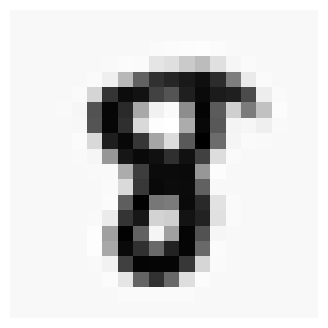

In [39]:
# Apresentando imagem do digito e sua predição
if indices.size > 0:
    i, indices = indices[0], indices[1:]
    displayData(X[i, :], figsize=(4, 4))
    pred = predict(Theta1, Theta2, X[i, :])
    print('Neural Network Prediction: {}'.format(*pred))
else:
    print('No more images to display!')